# DataLoader Augmentation Sanity Check

In [1]:
import monai.transforms as mt
from torch.utils.data import DataLoader

from sage.data import UKBDataset
import sage.constants as C
import sage.xai.nilearn_plots as nilp_

In [2]:
ds = UKBDataset()
dl = DataLoader(ds, shuffle=True, batch_size=4)

batch = next(iter(dl))

INFO:sage.data.dataloader:Setting up UKBiobank Dataset
INFO:sage.data.dataloader:No exclusion file found. biobank/exclusion.csv
INFO:sage.data.dataloader:Total 33007 files of train h5 exist


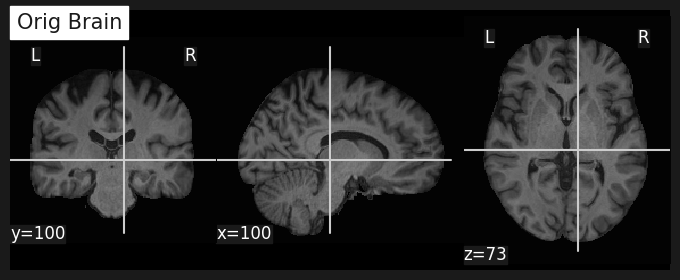

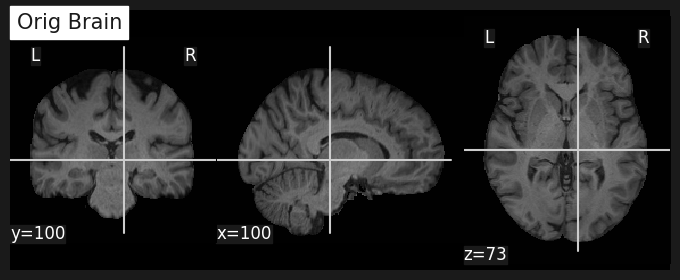

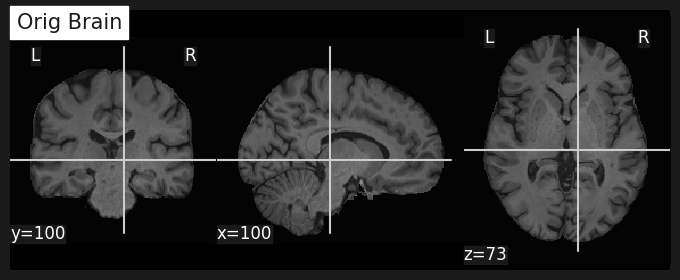

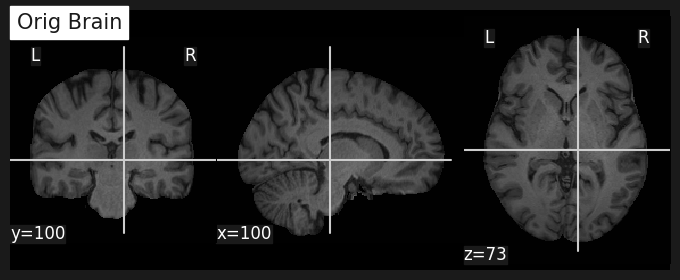

In [3]:
# orig brain plot
cut_coords = (100, 100, 73)
for brain in batch["brain"]:
     nilp_.plot_brain(brain.numpy(), cut_coords=cut_coords, title="Orig Brain")

In [4]:
# Hard-copied Augmentation from trainer.py
transforms = mt.Compose([
    mt.Resize(spatial_size=C.SPATIAL_SIZE),
    mt.ScaleIntensity(channel_wise=True),
    mt.RandAdjustContrast(prob=0.1, gamma=(0.5, 2.0)),
    mt.RandCoarseDropout(holes=20, spatial_size=8, prob=0.4, fill_value=0.),
    mt.RandAxisFlip(prob=0.5),
    mt.RandZoom(prob=0.4, min_zoom=0.9, max_zoom=1.4, mode="trilinear"),  
])

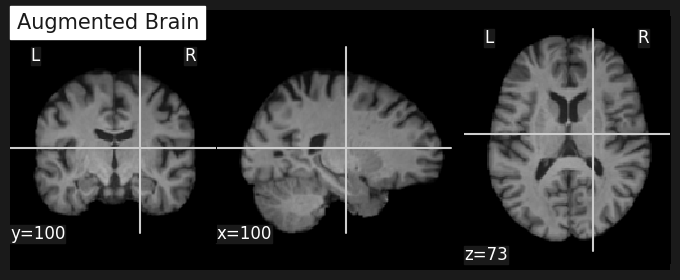

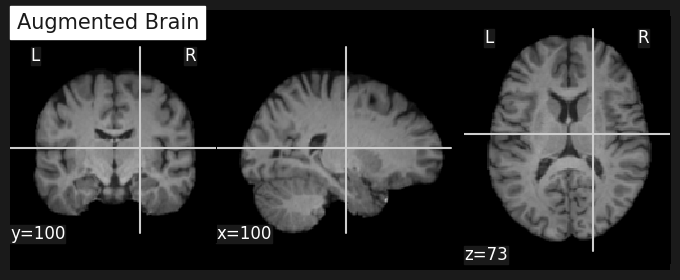

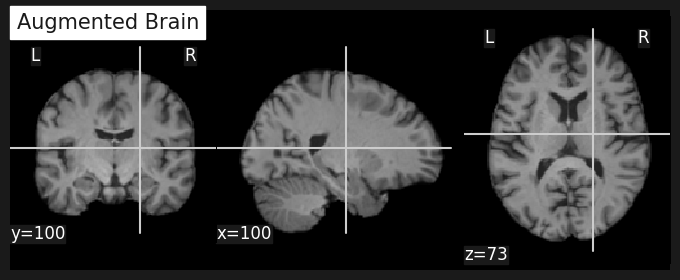

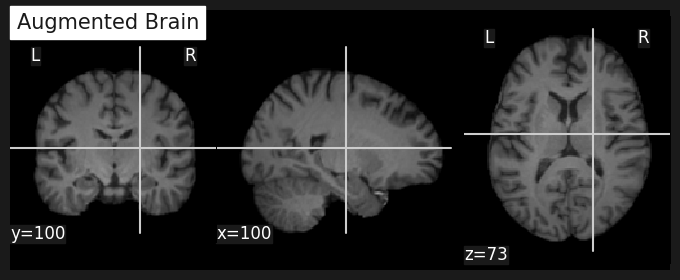

In [5]:
# orig brain plot
aug_brain = transforms(batch["brain"].squeeze()).unsqueeze(dim=1)
for brain in aug_brain:
     nilp_.plot_brain(brain.numpy(), cut_coords=cut_coords, title="Augmented Brain")

Batch 단위로 적용하고 있는데 `batch_size`를 작게 주고 accumulate_grad_batches를 늘려서 배치마다 다르게 적용받는 것처럼 효과를 줘야할 것 같다.

In [6]:
from sage.data.mask import UKB_MaskDataset

normal_ds = UKBDataset()

mask_idx = [2, 4]
masked_ds = UKB_MaskDataset(atlas_name="dkt", mask_idx=mask_idx)
masked_atlas = masked_ds.mask

INFO:sage.data.dataloader:Setting up UKBiobank Dataset
INFO:sage.data.dataloader:No exclusion file found. biobank/exclusion.csv
INFO:sage.data.dataloader:Total 33007 files of train h5 exist
INFO:sage.data.dataloader:Setting up UKBiobank Dataset
INFO:sage.data.dataloader:No exclusion file found. biobank/exclusion.csv
INFO:sage.data.dataloader:Total 33007 files of train h5 exist
INFO:/home/1pha/codespace/brain-age-prediction/sage/xai/atlas.py:Load dkt atlas.
/home/1pha/codespace/brain-age-prediction/sage/xai/utils.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  arr = torch.tensor(arr)
INFO:/home/1pha/codespace/brain-age-prediction/sage/data/mask.py:RoI(s) to be masked out: [2, 4]
INFO:/home/1pha/codespace/brain-age-prediction/sage/data/mask.py:RoI(s) to be masked out: ['Left-Cerebral-White-Matter', 'Left-Lateral-Ventricle']
INFO:/ho

In [7]:
idx = 0

normal_sample = normal_ds[idx]["brain"]
masked_sample = masked_ds[idx]["brain"]

(<nilearn.plotting.displays._slicers.OrthoSlicer at 0x7f00f88a1780>, None)

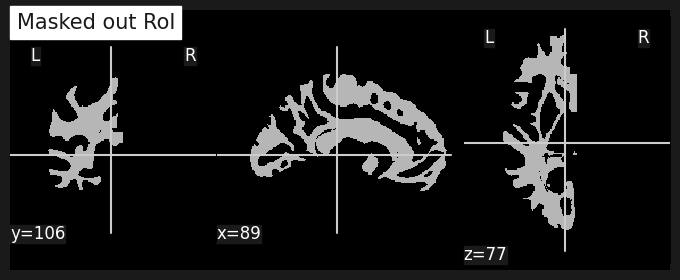

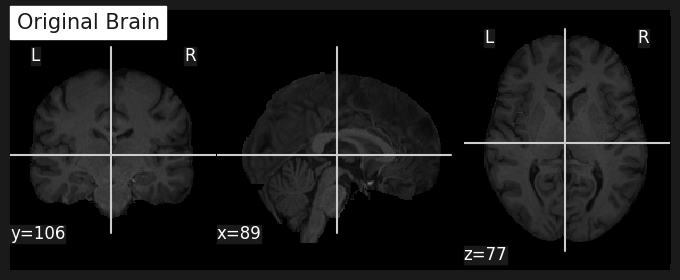

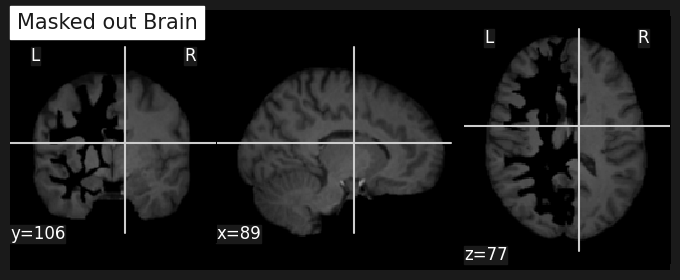

In [8]:
cut_coords = (89, 106, 77)

nilp_.plot_brain(masked_atlas.astype(float), cut_coords=cut_coords, title="Masked out RoI")
nilp_.plot_brain(normal_sample, cut_coords=cut_coords, title="Original Brain")
nilp_.plot_brain(masked_sample, cut_coords=cut_coords, title="Masked out Brain")